In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/home/xhding/workspaces/torch-deep-retina')
import os
import scipy
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyret
from kinetic.evaluation import *
from kinetic.utils import *
from kinetic.config import get_custom_cfg
from kinetic.data import *
from kinetic.notebook.functions import *
import kinetic.models as models
from kinetic.models import *

In [5]:
with h5py.File('/home/xhding/tem_stim/21-01-262/fullfield.h5', 'r') as f:
    stimulus =  np.asarray(f['train']['stimulus'][:, 25, 25]).astype('float32')
    resp = np.asarray(f['train']['response']['firing_rate_10ms'])

In [10]:
stimuli = stimulus[:40060].reshape((10,-1))
responses = np.swapaxes(resp, 0, 1)[:40060].reshape((10, -1, 11))

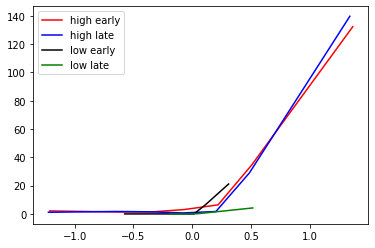

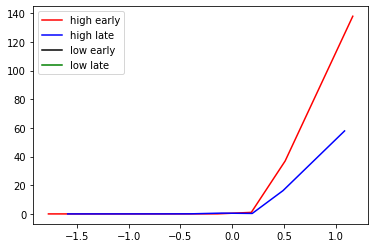

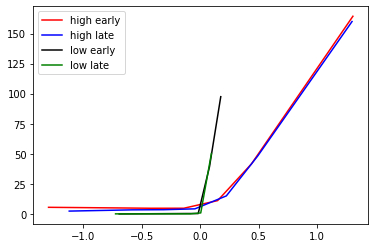

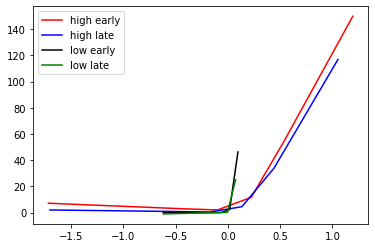

In [11]:
for cell in [1, 2, 7, 10]:
    _, x_he, nonlinear_he = LN_model_multi_trials_fourier(stimuli, responses, 0.35, cell, 0, 500)
    _, x_hl, nonlinear_hl = LN_model_multi_trials_fourier(stimuli, responses, 0.35, cell, 1400, 2000)
    _, x_le, nonlinear_le = LN_model_multi_trials_fourier(stimuli, responses, 0.05, cell, 2000, 2500)
    _, x_ll, nonlinear_ll = LN_model_multi_trials_fourier(stimuli, responses, 0.05, cell, 3400, 4000)
    plt.plot(x_he, nonlinear_he, 'r', label='high early')
    plt.plot(x_hl, nonlinear_hl, 'b', label='high late')
    plt.plot(x_le, nonlinear_le, 'k', label='low early')
    plt.plot(x_ll, nonlinear_ll, 'g', label='low late')
    plt.legend()
    plt.show()

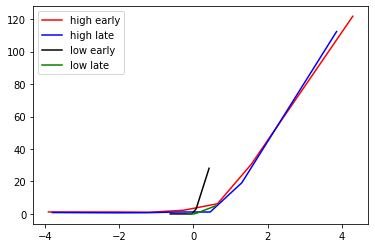

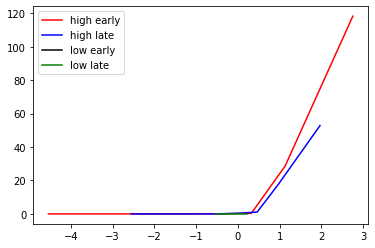

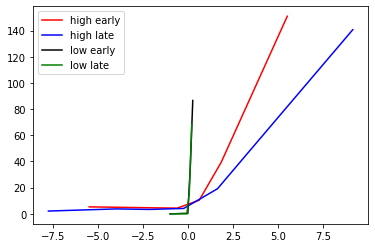

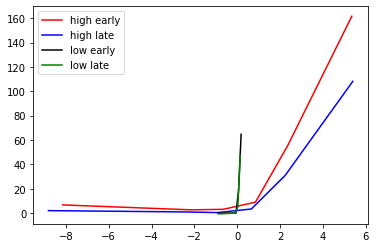

In [12]:
for cell in [1,2,7,10]:
    _, x_he, nonlinear_he = LN_model_multi_trials(stimuli, responses, 0.35, cell, 0, 500, sta_type='revcor')
    _, x_hl, nonlinear_hl = LN_model_multi_trials(stimuli, responses, 0.35, cell, 1400, 2000, sta_type='revcor')
    _, x_le, nonlinear_le = LN_model_multi_trials(stimuli, responses, 0.05, cell, 2000, 2500, sta_type='revcor')
    _, x_ll, nonlinear_ll = LN_model_multi_trials(stimuli, responses, 0.05, cell, 3400, 4000, sta_type='revcor')
    plt.plot(x_he, nonlinear_he, 'r', label='high early')
    plt.plot(x_hl, nonlinear_hl, 'b', label='high late')
    plt.plot(x_le, nonlinear_le, 'k', label='low early')
    plt.plot(x_ll, nonlinear_ll, 'g', label='low late')
    plt.legend()
    plt.show()

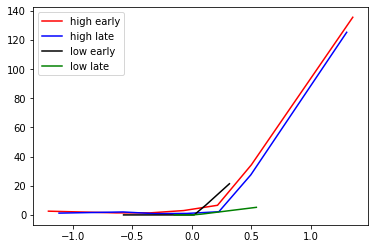

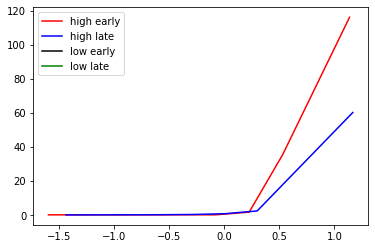

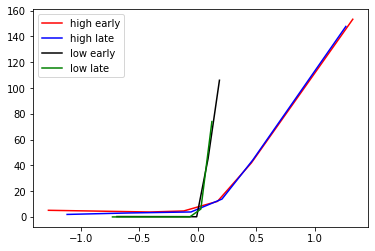

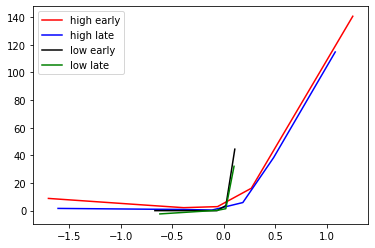

In [13]:
for cell in [1,2,7,10]:
    _, x_he, nonlinear_he = LN_model_multi_trials(stimuli, responses, 0.35, cell, 0, 500, sta_type='fourier')
    _, x_hl, nonlinear_hl = LN_model_multi_trials(stimuli, responses, 0.35, cell, 1400, 2000, sta_type='fourier')
    _, x_le, nonlinear_le = LN_model_multi_trials(stimuli, responses, 0.05, cell, 2000, 2500, sta_type='fourier')
    _, x_ll, nonlinear_ll = LN_model_multi_trials(stimuli, responses, 0.05, cell, 3400, 4000, sta_type='fourier')
    plt.plot(x_he, nonlinear_he, 'r', label='high early')
    plt.plot(x_hl, nonlinear_hl, 'b', label='high late')
    plt.plot(x_le, nonlinear_le, 'k', label='low early')
    plt.plot(x_ll, nonlinear_ll, 'g', label='low late')
    plt.legend()
    plt.show()

In [27]:
cfg = get_custom_cfg('kinetics_both')
device = torch.device('cuda:0')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint = torch.load('/home/xhding/saved_model/kinetics_both/epoch_010_loss_-54.94_pearson_natural_0.4181_pearson_noise_0.3763.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
data_kwargs = dict(cfg.Data)
data_kwargs['stim'] = 'naturalscene'
train_dataset_natural = MyDataset(stim_sec='train', **data_kwargs)
test_data_natural =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_natural.stats, **data_kwargs))
data_kwargs['stim'] = 'fullfield_whitenoise'
train_dataset_noise = MyDataset(stim_sec='train', **data_kwargs)
test_data_noise =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_noise.stats, **data_kwargs))

In [28]:
pearson = pearsonr_eval(model, test_data_natural, 4, device)
print(pearson)

0.5924798024010967


In [29]:
pearson = pearsonr_eval(model, test_data_noise, 4, device)
print(pearson)

0.5276330074086482
